# Visium Mouse Kidney

This example uses TACCO to annotate and analyse 2 mouse kidney Visium samples (1), (2) with mouse kidney scRNA-seq data as reference (3).

(1) Visium spatial gene expression from adult C57BL/6 mouse kidney, (v1, FFPE), Spatial Gene Expression Dataset by Space Ranger 1.3.0, 10x Genomics, (2021, August 16).
https://www.10xgenomics.com/resources/datasets/adult-mouse-kidney-ffpe-1-standard-1-3-0

(2) Visium spatial gene expression from adult C57BL/6 mouse kidney section (coronal), (v1, FF), Spatial Gene Expression Dataset by Space Ranger 1.1.0, 10x Genomics (2020, June 23). 
https://www.10xgenomics.com/resources/datasets/mouse-kidney-section-coronal-1-standard-1-1-0

(3) The Tabula Muris Consortium., Overall coordination., Logistical coordination. et al. Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris. Nature 562, 367–372 (2018). https://doi.org/10.1038/s41586-018-0590-4.

In [1]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc

import squidpy as sq
import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Load data

Visium data is loaded from a prepared `.h5ad` file, which is created in file `workflow/visium_mouse_kidney/prepVisium_mouse_spatial_data.py` using squidpy, e.g., `adata = sq.read.visium(visium_path)`

In [2]:
data_path = common_code.find_path('results/visium_mouse_kidney/data')
plot_path = common_code.find_path('results/visium_mouse_kidney')

In [3]:
reference = ad.read(f'{data_path}/TabulaMurisKidney.h5ad')
slide_1 = ad.read(f'{data_path}/MouseKidney_visium.h5ad')
slide_1.var_names_make_unique()
slide_2 = ad.read(f'{data_path}/MouseKidneyCoronal_v110_visium.h5ad')
slide_2.var_names_make_unique()

Later, we want to annotate both slides consistently, so we merge their data into a single Anndata object.

In [4]:
# Merge slides
slide_m = ad.concat([slide_1,slide_2], index_unique="_")
slide_m.obs['slide'] = slide_m.obs['slide'].astype("category")

## Plotting options

In [5]:
matplotlib.rcParams['figure.dpi'] = 100.0

axsize = np.array([4,3])*0.5

## Cell types

In [6]:
# Annotate with merged slides
tc.tl.annotate(slide_m,reference,'cell_ontology_class',result_key='cell_ontology_class',multi_center=3,lamb=1e-3)

Starting preprocessing
Annotation profiles were not found in `reference.varm["cell_ontology_class"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 3.86 seconds.
Starting annotation of data with shape (4562, 13585) and a reference of shape (2781, 13585) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=cell_ontology_class, normalize_to=adata
   +- multi center: multi_center=3 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None lamb=0.001
mean,std( rescaling(gene) )  26.4315379362136 236.33741338800488
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 24.69 seconds.


AnnData object with n_obs × n_vars = 4562 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'slide'
    uns: 'cell_ontology_class_mc3'
    obsm: 'spatial', 'cell_ontology_class_mc3', 'cell_ontology_class'
    varm: 'cell_ontology_class_mc3'

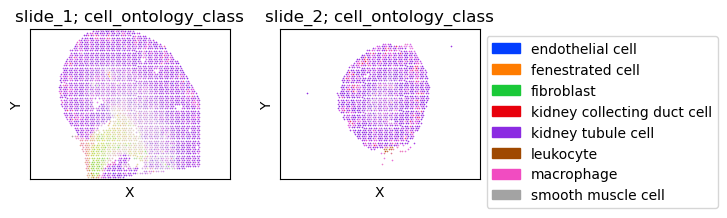

In [7]:
fig = tc.pl.scatter(slide_m, keys='cell_ontology_class', group_key='slide', position_key=['x','y'], joint=True, point_size=1, axsize=axsize, noticks=True, axes_labels=['X','Y'], );

## Regions

In [8]:
# Find consistent regions on merged slides
tc.tl.find_regions(slide_m,key_added='regions',batch_key='slide',position_weight=20,resolution=1.0,annotation_key=None,amplitudes=False,cross_batch_overweight_factor=100,n_neighbors=1000)
slide_m.obs['regions'] = slide_m.obs['regions'].map(lambda x: f'region_{x}').astype('category')

         Falling back to preprocessing with `sc.pp.pca` and default params.


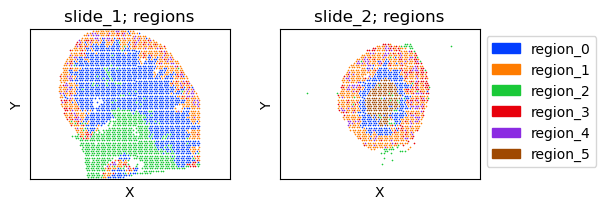

In [9]:
fig = tc.pl.scatter(slide_m,keys='regions',group_key='slide',joint=True,axsize=axsize,point_size=1,noticks=True,axes_labels=['X','Y'],share_scaling=True);

## Squidpy Plots

Tacco's analysis does not create custom objects, and relies on the functionality in Anndata instead. Therefore other Anndata-based tools can be included in Tacco workflows, as well, e.g., Squidpy for the visualization of annotation on top of the Visium H&E image.

In [10]:
slide_1.obs_names = slide_1.obs_names.map(lambda x: x + "_0")
slide_2.obs_names = slide_2.obs_names.map(lambda x: x + "_1")

In [11]:
# Map annotations back to original adatas 
for col in slide_m[slide_m.obs["slide"]=="slide_1"].obsm["cell_ontology_class"].columns:
    slide_1.obs[col] = slide_m.obsm["cell_ontology_class"][col]

for col in slide_m[slide_m.obs["slide"]=="slide_2"].obsm["cell_ontology_class"].columns:
    slide_2.obs[col] = slide_m.obsm["cell_ontology_class"][col]

slide_1.obs["regions"] = slide_m[slide_m.obs["slide"]=="slide_1"].obs["regions"]    
slide_2.obs["regions"] = slide_m[slide_m.obs["slide"]=="slide_2"].obs["regions"]    

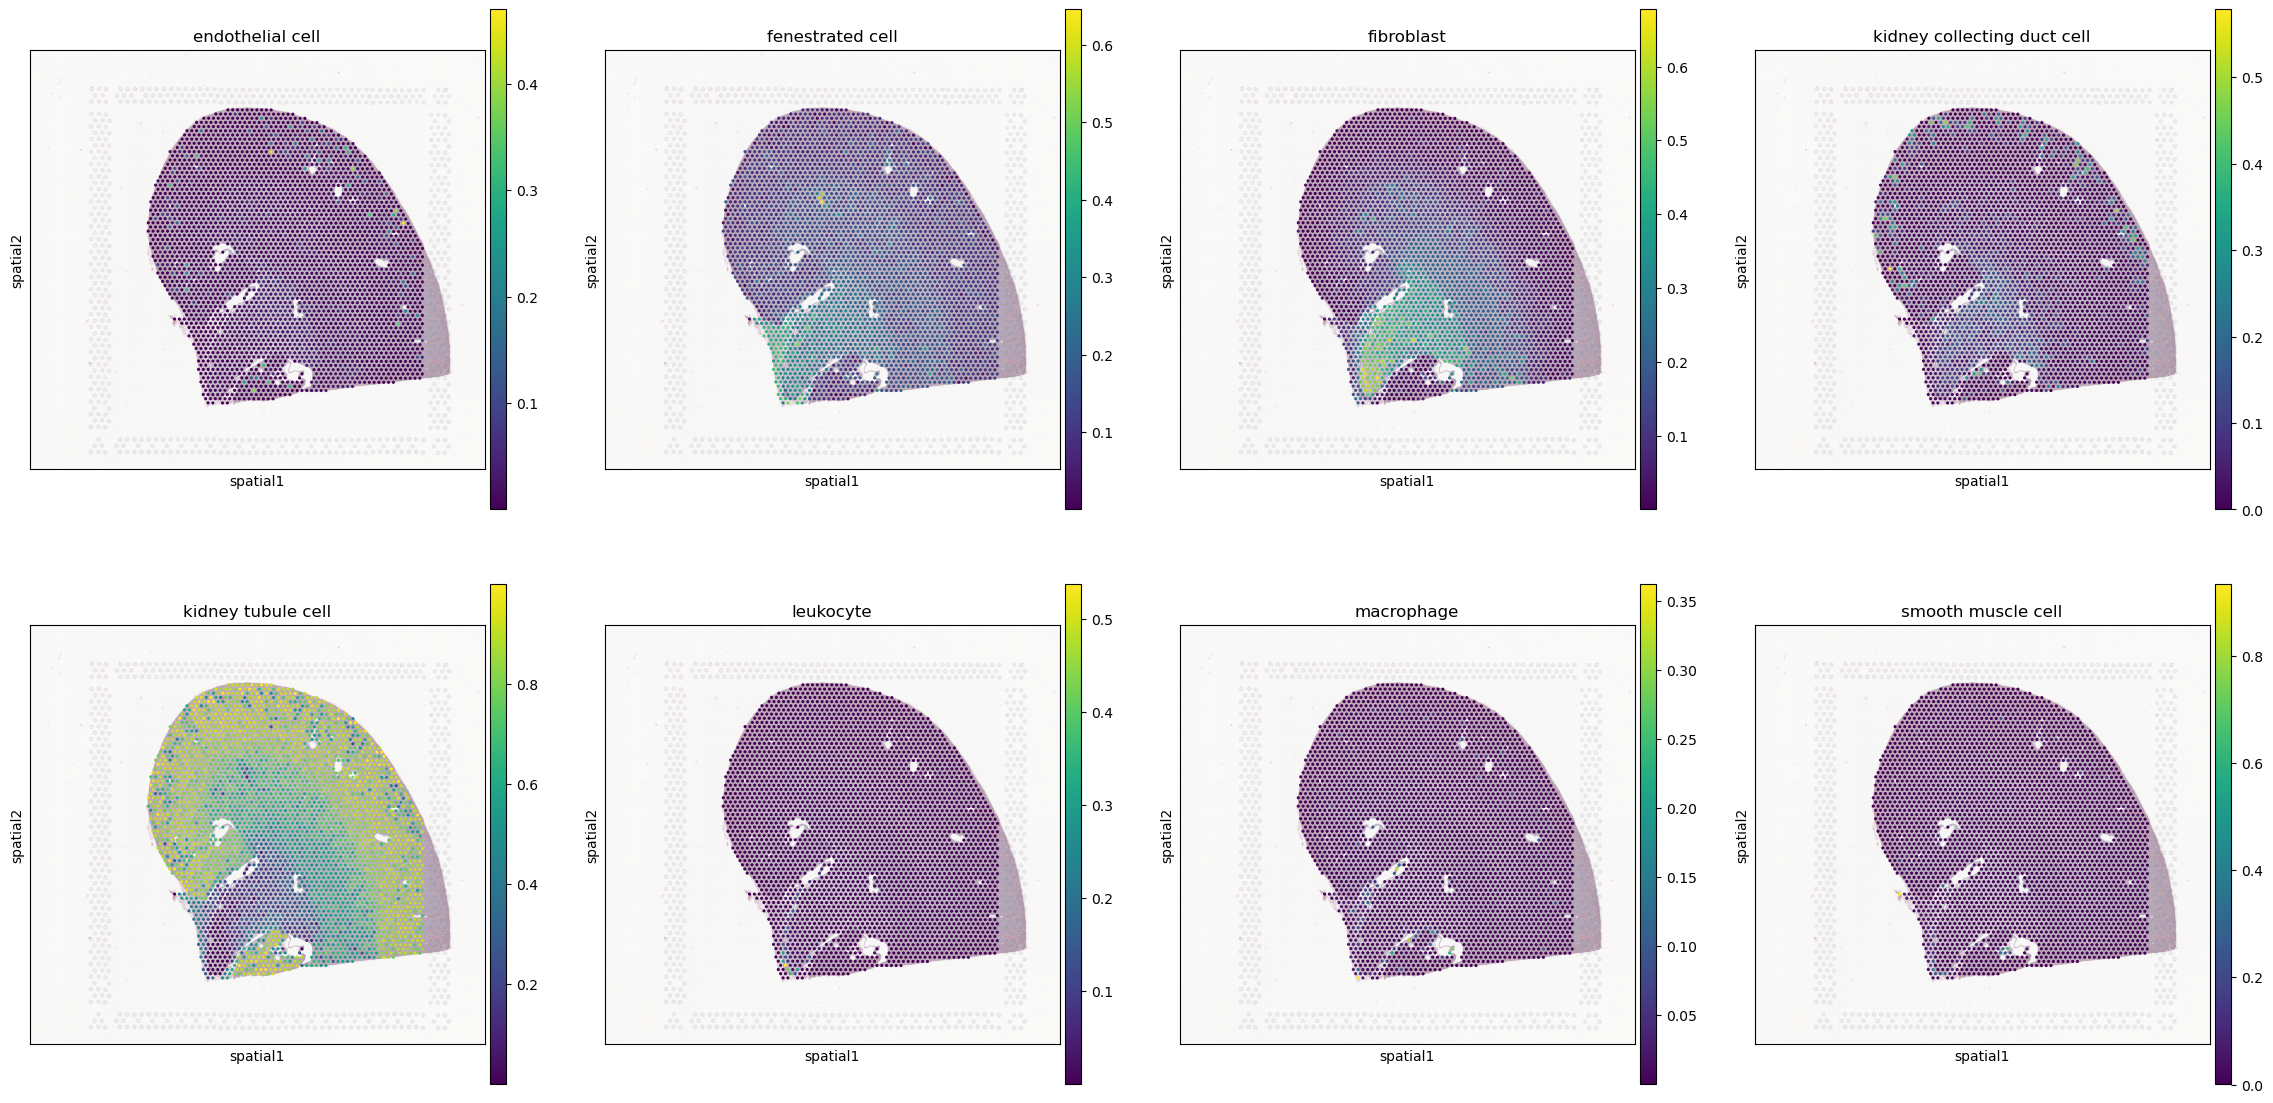

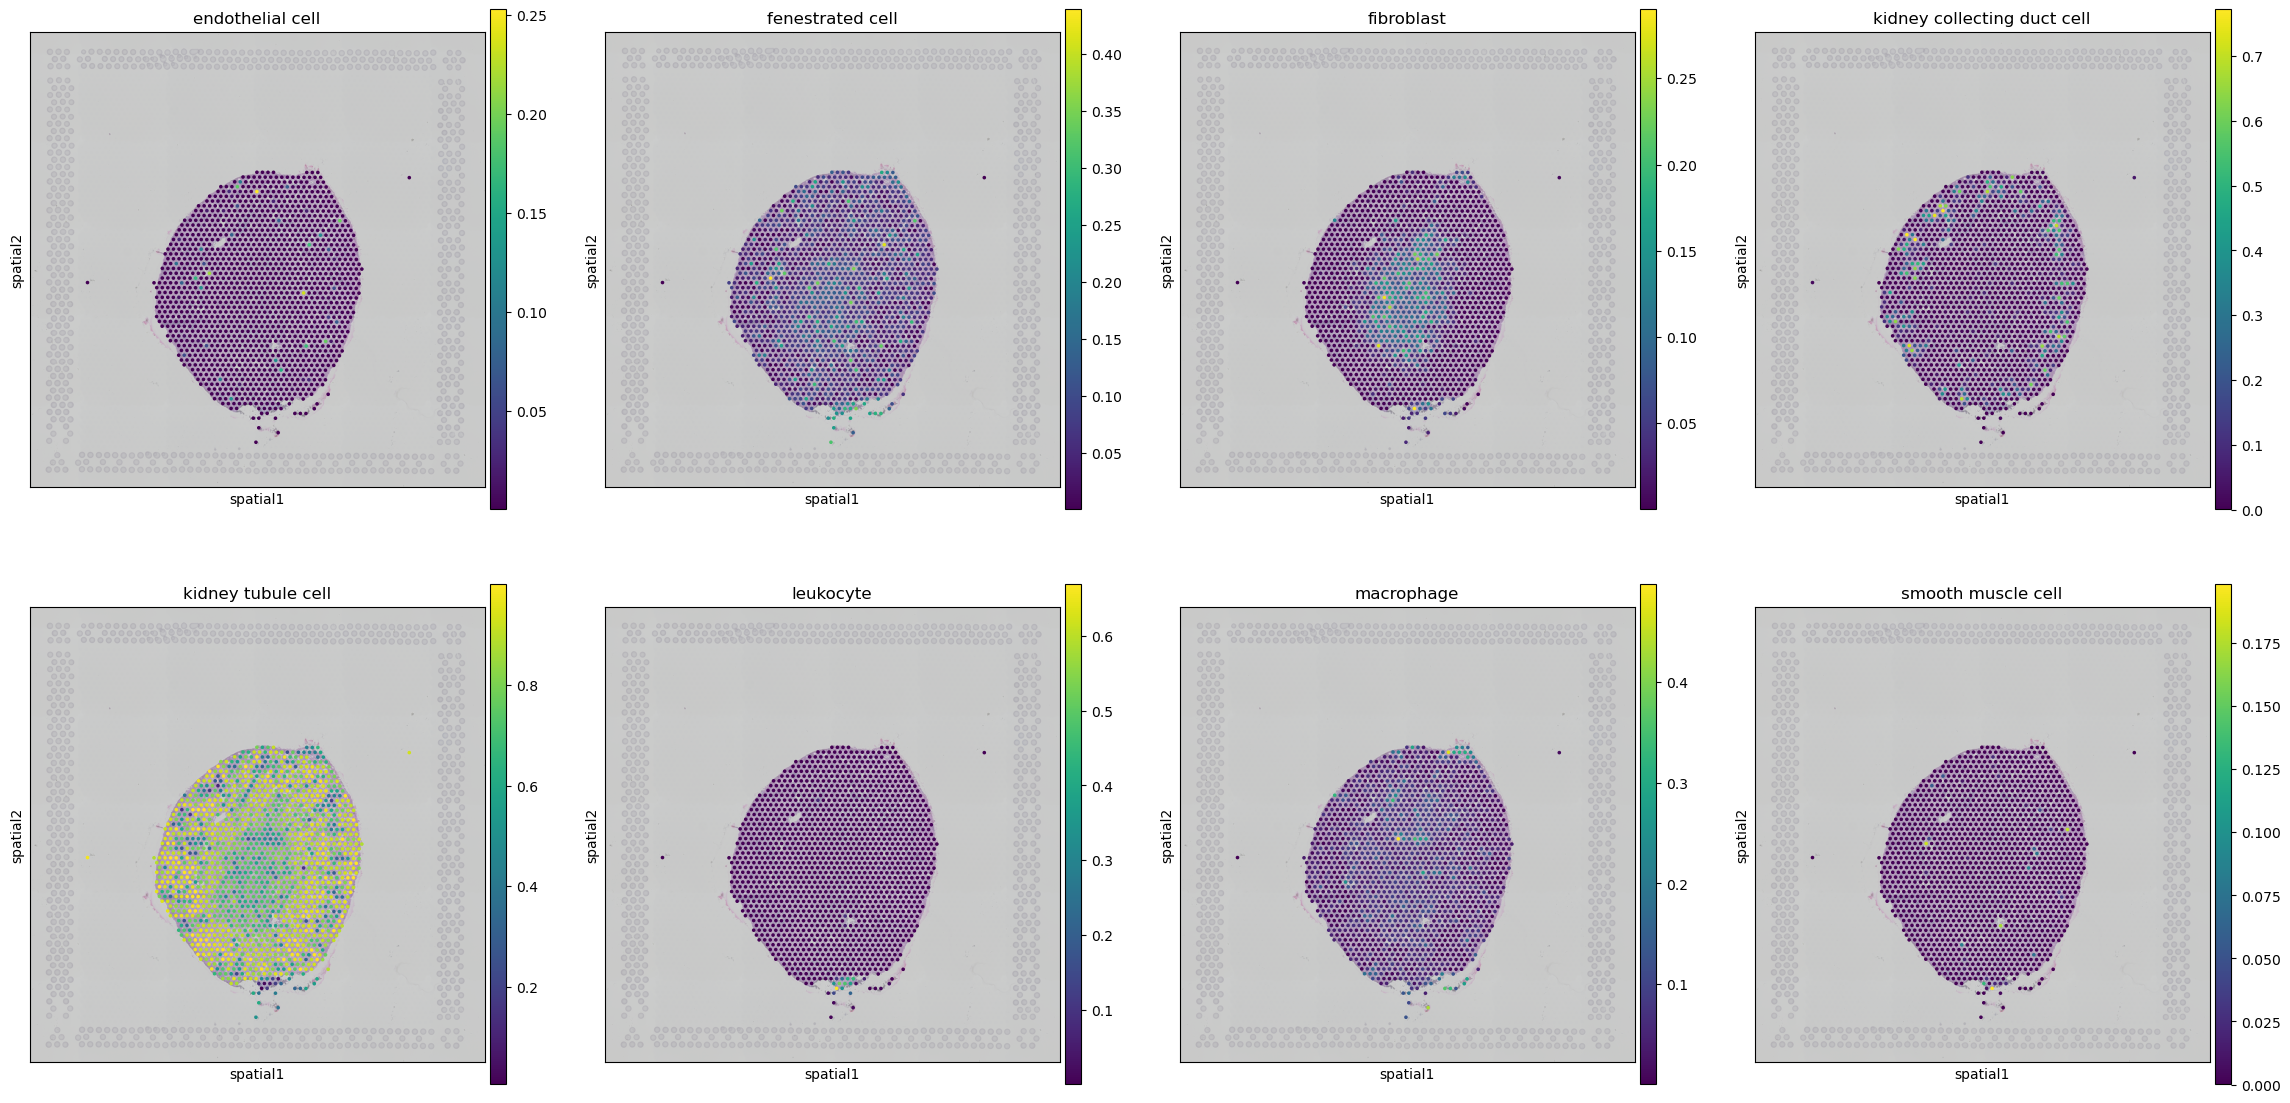

In [12]:
celltypes = ['endothelial cell', 'fenestrated cell', 'fibroblast', 'kidney collecting duct cell', 'kidney tubule cell', 'leukocyte', 'macrophage', 'smooth muscle cell']
for slide in [slide_1, slide_2]:
    fig, axes = tc.pl.subplots(n_x = 4, n_y = 2);
    axes = np.ravel(axes)
    for j, celltype in enumerate(celltypes):
        sq.pl.spatial_scatter(slide, library_key='hires', color=celltype, ax=axes[j], img_alpha=0.5)
    axes = np.reshape(axes, (4,2))
    plt.show()

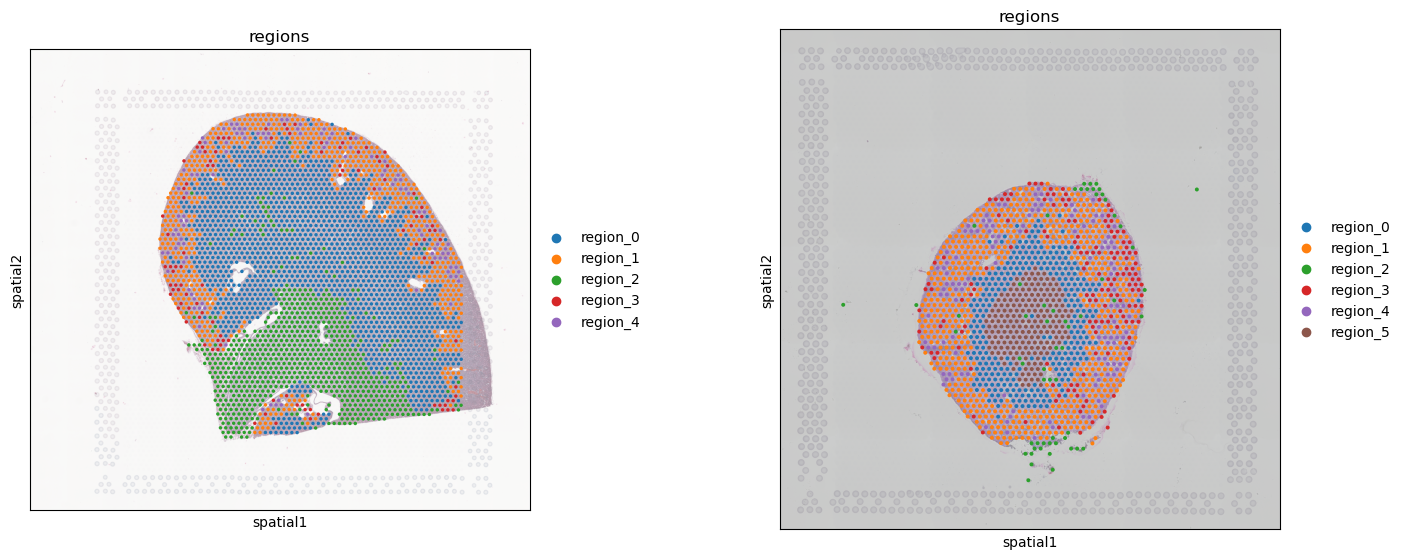

In [13]:
fig, axes = tc.pl.subplots(n_x=2, n_y=1, wspace=.5)
sq.pl.spatial_scatter(slide_1, library_key='hires', color="regions", ax=axes[0][0], img_alpha=0.5);
sq.pl.spatial_scatter(slide_2, library_key='hires', color="regions", ax=axes[0][1], img_alpha=0.5);